<md>References:

https://towardsdatascience.com/how-to-implement-graph-rag-using-knowledge-graphs-and-vector-databases-60bb69a22759

https://neo4j.com/blog/graphrag-manifesto/

https://spg.openkg.cn/en-US

https://github.com/OpenSPG/KAG

https://openspg.yuque.com/ndx6g9/cwh47i/rs7gr8g4s538b1n7#cikso

https://arxiv.org/abs/2409.13731

https://medium.com/@zilliz_learn/graphrag-explained-enhancing-rag-with-knowledge-graphs-3312065f99e1

https://medium.com/@zilliz_learn/graphrag-explained-enhancing-rag-with-knowledge-graphs-3312065f99e1


</md>


KAG (Knowledge Augmented Generation):

**Integration of Knowledge Graphs:** KAG incorporates structured knowledge graphs, allowing better understanding and reasoning with domain-specific facts. <br>
**Enhanced Reasoning:** Combines symbolic and LLM-driven reasoning to handle complex, multi-step logical reasoning tasks.

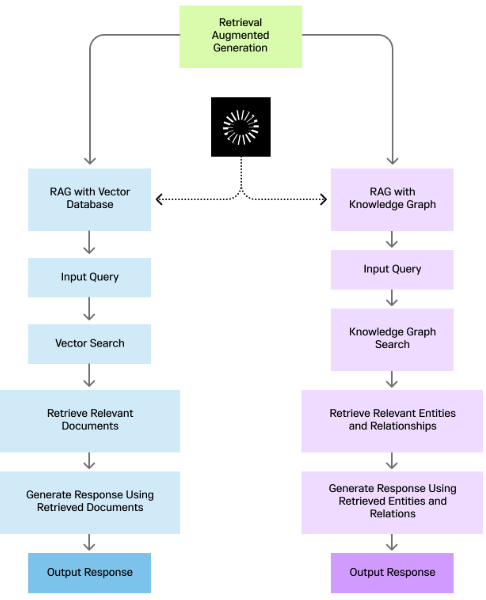

##GraphRAG with Milvus Vector Database

In [1]:
!pip install pymilvus git+https://github.com/zc277584121/graphrag.git

  Cloning https://github.com/zc277584121/graphrag.git to /tmp/pip-req-build-5rofwfug
  Running command git clone --filter=blob:none --quiet https://github.com/zc277584121/graphrag.git /tmp/pip-req-build-5rofwfug
  Resolved https://github.com/zc277584121/graphrag.git to commit c7263931eb9b3b6c7cd72fc11e4a6d4b11e6d48b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import nest_asyncio
nest_asyncio.apply()

import os
import urllib.request

In [3]:
index_root = os.path.join(os.getcwd(), 'graphrag_index')
os.makedirs(os.path.join(index_root, 'input'), exist_ok=True)
url = "https://www.gutenberg.org/cache/epub/7785/pg7785.txt"
file_path = os.path.join(index_root, 'input', 'davinci.txt')
urllib.request.urlretrieve(url, file_path)
with open(file_path, 'r+', encoding='utf-8') as file:
    # We use the first 934 lines of the text file, because the later lines are not relevant for this example.
    # If you want to save api key cost, you can truncate the text file to a smaller size.
    lines = file.readlines()
    file.seek(0)
    file.writelines(lines[:934])  # Decrease this number if you want to save api key cost.
    file.truncate()

In [4]:
!python -m graphrag.index --init --root ./graphrag_index

2025-01-09 09:02:25.316102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 09:02:25.343543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 09:02:25.352250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 09:02:27.086169: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Initializing project at ./graphrag_index
⠋ GraphRAG Indexer 

In [5]:
!python -m graphrag.index --root ./graphrag_index

2025-01-09 09:03:13.826697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 09:03:13.857031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 09:03:13.869403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 09:03:15.304526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
🚀 Reading settings from graphrag_index/settings.yaml
⠇ GraphRAG Indexer 
⠇ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (0 filtered) ━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:00
⠇ GraphRAG Indexer 
├── Loading Input (text) - 

In [6]:
import os

import pandas as pd
import tiktoken
from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    # read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores import MilvusVectorStore
output_dir = os.path.join(index_root, "output")
subdirs = [os.path.join(output_dir, d) for d in os.listdir(output_dir)]
latest_subdir = max(subdirs, key=os.path.getmtime)  # Get latest output directory


INPUT_DIR = os.path.join(latest_subdir, "artifacts")
COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 2


In [7]:
import os
import pandas as pd

# ... (other imports and code)

# Get a list of all subdirectories within the output directory
output_dir = os.path.join(index_root, "output")
subdirs = [
    os.path.join(output_dir, d)
    for d in os.listdir(output_dir)
    if os.path.isdir(os.path.join(output_dir, d))
]

# Check if any subdirectories were found
if subdirs:
    latest_subdir = max(subdirs, key=os.path.getmtime)  # Get latest output directory
    INPUT_DIR = os.path.join(latest_subdir, "artifacts")
else:
    # Handle the case where no subdirectories are found (e.g., indexing not completed)
    raise FileNotFoundError(f"No output directories found in {output_dir}. Make sure the indexing process has completed successfully.")

# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")
entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)
description_embedding_store = MilvusVectorStore(
    collection_name="entity_description_embeddings",
)
# description_embedding_store.connect(uri="http://localhost:19530") # For Milvus docker service
description_embedding_store.connect(uri="./milvus.db") # For Milvus Lite
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)
print(f"Entity count: {len(entity_df)}")
entity_df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/graphrag_index/output/20250109-090327/artifacts/create_final_nodes.parquet'

In [ ]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

In [ ]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

In [ ]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

In [ ]:
print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

In [8]:
api_key = os.environ["OPENAI_API_KEY"]  # Your OpenAI API key
llm_model = "gpt-4o"  # Or gpt-4-turbo-preview
embedding_model = "text-embedding-3-small"

KeyError: 'OPENAI_API_KEY'

In [ ]:
llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,
    max_retries=20,
)
token_encoder = tiktoken.get_encoding("cl100k_base")
text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=None,
    api_type=OpenaiApiType.OpenAI,
    model=embedding_model,
    deployment_name=embedding_model,
    max_retries=20,
)
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    covariates=None, #covariates,#todo
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)
local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}
llm_params = {
    "max_tokens": 2_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": 0.0,
}
search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="multiple paragraphs",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

In [ ]:
result = await search_engine.asearch("Tell me about Leonardo Da Vinci")
print(result.response)

## GraphRAG with Milvus